In [3]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent.parent
sys.path.append(str(parent_dir))
from instruments import *
from physical_models import *
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "lines.linewidth": 3,
})

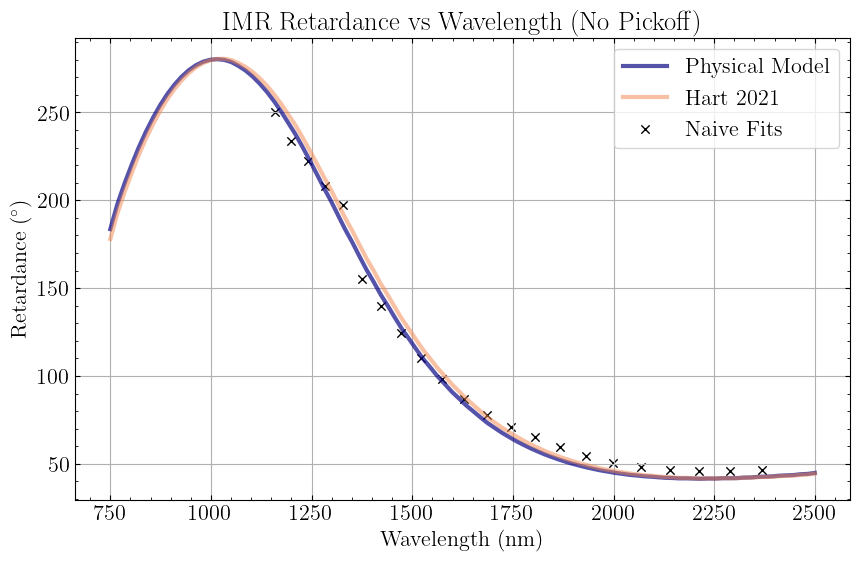

In [3]:
# Use results from minimization to make imr plot

wsio2, wmgf2, d = [1.645, 1.285, 259.50747]
hart = [1.623,1.268,262.56]
nodegen = [1.622, 1.268, 259.5]
wavelengths = np.linspace(750,2500,100)
json_dir = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/system_dicts_no_pickoff_cal')
params,fig,ax = plot_config_dict_vs_wavelength('image_rotator', 'phi',json_dir, title= 'IMR Retardance vs Wavelength (No Pickoff)', axtitle='Retardance ($^{\circ}$)')
cmap = plt.get_cmap('plasma')
ax.plot(wavelengths,np.rad2deg(IMR_retardance(wavelengths,d)), color=cmap(0.0), alpha = 0.7, label = 'Physical Model')
#ax.plot(wavelengths,np.rad2deg(IMR_retardance(wavelengths,nodegen[2])), color=cmap(0.3), alpha = 0.5, label = 'Removed Degeneracy')
ax.plot(wavelengths,np.rad2deg(IMR_retardance(wavelengths,hart[2])), color=cmap(0.7), alpha = 0.5, label = 'Hart 2021')
ax.scatter([], [], marker='x',color='black' ,label='Naive Fits', linewidths=1)
ax.legend()
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#plt.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/plots/imr_retardance_v_wavelength_nopick.png', bbox_inches='tight', dpi=600)


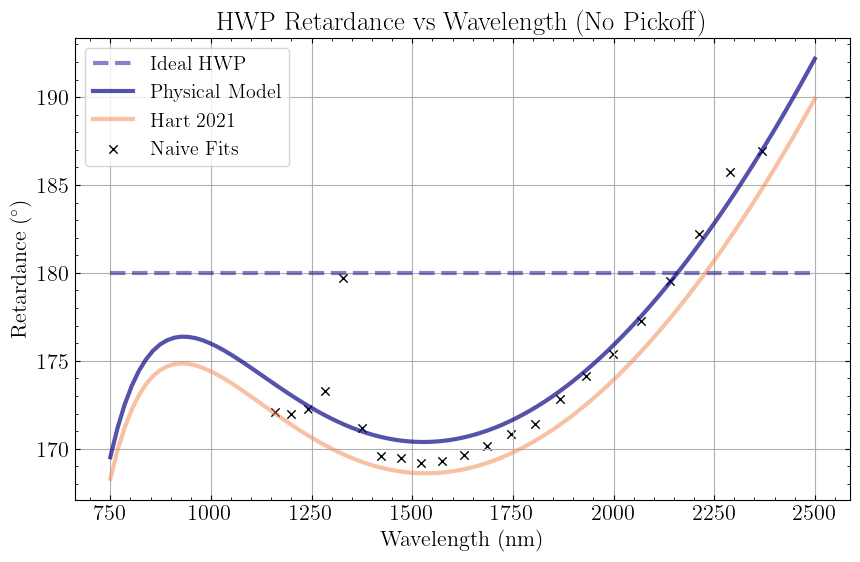

In [37]:
# now do hwp retardance

params,fig,ax = plot_config_dict_vs_wavelength('hwp', 'phi',json_dir, title= 'HWP Retardance vs Wavelength (No Pickoff)', axtitle='Retardance ($^{\circ}$)')
ax.plot(wavelengths, np.repeat(180, 100), color=cmap(1), alpha= 0.5,linestyle='--', label='Ideal HWP')
ax.plot(wavelengths, np.rad2deg(HWP_retardance(wavelengths, wsio2, wmgf2)), color=cmap(0), alpha=0.7, label='Physical Model')
#ax.plot(wavelengths,np.rad2deg(HWP_retardance(wavelengths,nodegen[0],nodegen[1])), color=cmap(0.3), alpha = 0.5, label = 'Removed Degeneracy')
ax.plot(wavelengths,np.rad2deg(HWP_retardance(wavelengths,hart[0],hart[1])), color=cmap(0.7), alpha = 0.5, label = 'Hart 2021')
ax.scatter([], [], marker='x', color='black', label='Naive Fits', linewidths=1)
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  # both major and minor
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)

# Show minor ticks
ax.minorticks_on()
plt.legend(fontsize=14.5)
#plt.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/plots/hwp_retardance_v_wavelength_nopick.png', bbox_inches='tight', dpi=600)


Interleaved Values


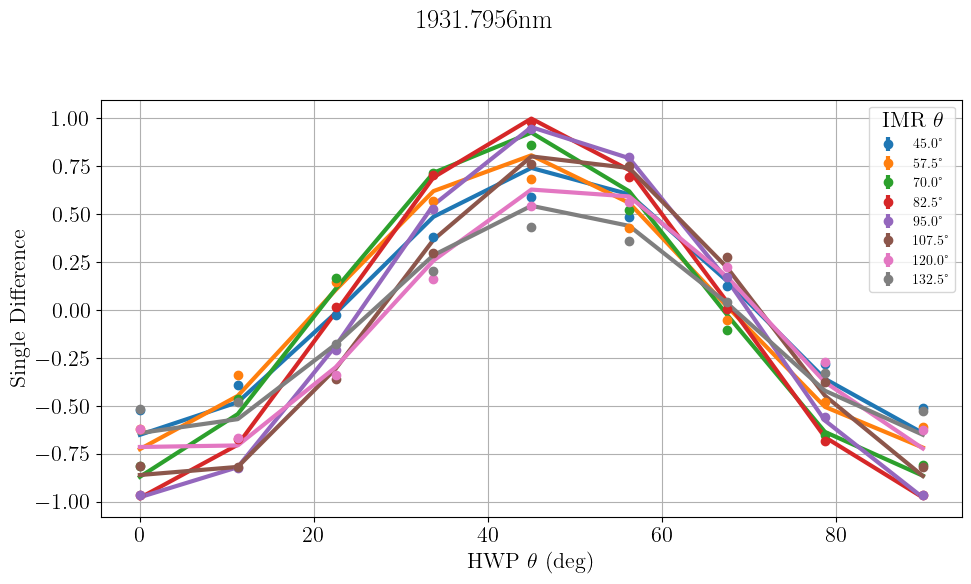

Residuals range: -0.15349213030819098 0.129174694147693


In [2]:
# Make a plot of the mcmc results
# Loading in MCMC fits

offset_imr = -0.27842 # derotator offset
offset_hwp = -2.09738 # HWP offset
offset_cal = -0.79060# calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)

# Load in data
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin15_no_pickoff.csv')
interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")


# Get our model retardances from Joost t Hart physical models

p = [HWP_retardance(wavelength_bins)[15], IMR_retardance(wavelength_bins)[15]]


# Gefine what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities, 'CHARIS')

# Plot the modeled and observed values


plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[15], mode='CHARIS',save_path='/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/plots/mcmcbin15.png')

# Print residuals (will be useful later to see if your fit improved at a quick glance)
residuals = interleaved_values[::2] - diffs_sums[::2]
print("Residuals range:", residuals.min(), residuals.max())


Interleaved Values


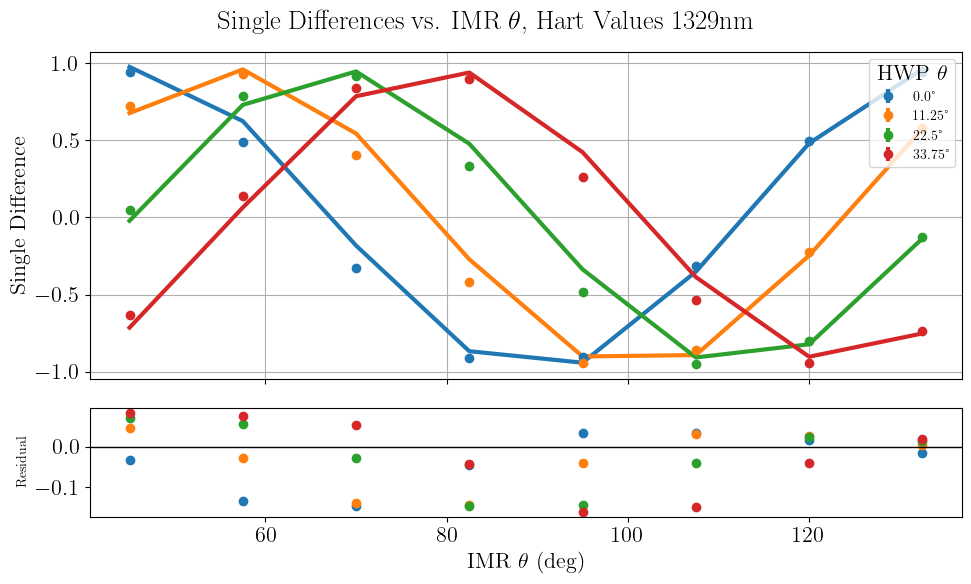

Residuals range: -0.18504576304108822 0.08395209131084502


In [4]:
# Make a plot of the mcmc results
# Loading in MCMC fits

offset_imr = -0.0118 # derotator offset
offset_hwp = -0.002 # HWP offset
offset_cal = -0.035# calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)

# Load in data
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin4_no_pickoff.csv')
interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")


# Get our model retardances from Joost t Hart physical models
wsio2_ = hart[0]
wmgf2_ = hart[1]
d_ = hart[2]
p = [HWP_retardance(wavelength_bins,wsio2_,wmgf2_)[4], IMR_retardance(wavelength_bins,d_)[4]]


# Gefine what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities, 'CHARIS')

# Plot the modeled and observed values


fig_imr, ax_imr,small_ax = plot_data_and_model_x_imr(interleaved_values, interleaved_stds, diffs_sums,configuration_list, hwp_theta_filter=[0,11.25,22.5,33.75],wavelength= wavelength_bins[4], title=r'Single Differences vs. IMR $\theta$, Hart Values 1329nm')
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  # both major and minor
)
ax_imr.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
from matplotlib.ticker import MultipleLocator
ax_imr.xaxis.set_minor_locator(MultipleLocator(1))
# Show minor ticks
ax_imr.minorticks_on()
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',
      # both major and minor
)
small_ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)




# Show minor ticks
small_ax.minorticks_on()
#fig_imr.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/plots/HART_vs_imr_1329nm.png', bbox_inches='tight', dpi=600)


# Print residuals (will be useful later to see if your fit improved at a quick glance)
residuals = interleaved_values[::2] - diffs_sums[::2]
print("Residuals range:", residuals.min(), residuals.max())
